In [30]:
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
import plotly.express as px

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score

In [5]:
data = pd.read_csv("data_for_models.csv")

In [6]:
data.fillna(0, inplace=True)

In [9]:
data.columns.to_list()

['Unnamed: 0',
 'striker',
 'totalrunsscored',
 'Total_batting_average',
 'batting_strike_rate',
 'totalballsfaced',
 'totalwickets',
 'economyrate',
 'oversbowled_clean']

                       totalrunsscored  Total_batting_average  \
totalrunsscored               1.000000               0.703139   
Total_batting_average         0.703139               1.000000   
batting_strike_rate           0.416145               0.621497   
totalballsfaced               0.994913               0.690230   
totalwickets                 -0.156821              -0.199768   
economyrate                  -0.266214              -0.322166   
oversbowled_clean            -0.142819              -0.190167   

                       batting_strike_rate  totalballsfaced  totalwickets  \
totalrunsscored                   0.416145         0.994913     -0.156821   
Total_batting_average             0.621497         0.690230     -0.199768   
batting_strike_rate               1.000000         0.389275     -0.150512   
totalballsfaced                   0.389275         1.000000     -0.150766   
totalwickets                     -0.150512        -0.150766      1.000000   
economyrate      

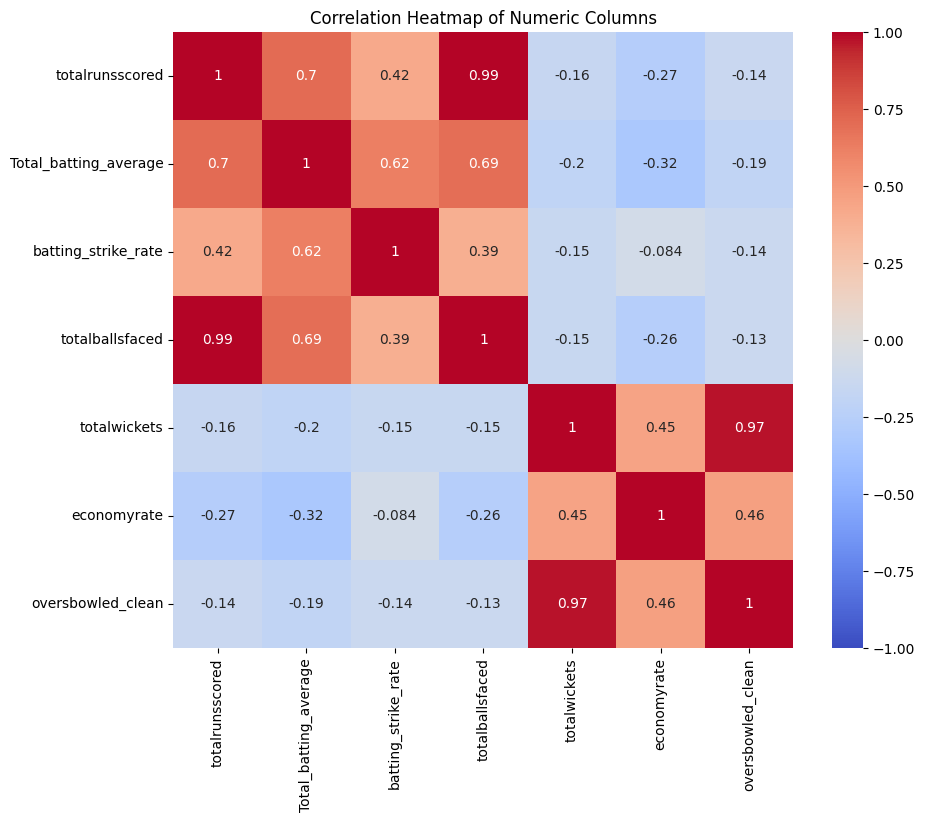

In [11]:
cr_data = data[['totalrunsscored',
 'Total_batting_average',
 'batting_strike_rate',
 'totalballsfaced',
 'totalwickets',
 'economyrate',
 'oversbowled_clean']]
cf = cr_data.corr()

# Print correlation matrix
print(cf)

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cf, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numeric Columns')
plt.show()

In [13]:
# Now see the distribution of runs scored in 2024 and 2023

# Create the histogram for runs in 2024
fig1 = px.histogram(data, x='totalrunsscored', 
                   title='runs in 2021 to 2024 distribution in Histogram', 
                   labels={'runsin2024': 'Runs scored', 'count': 'Frequency'})

# Store the result in a tuple
result1 = (fig1, 'Runs Histogram', 'Distribution of runs')




# To display the plot (if you're in a Jupyter notebook or similar environment)
fig1.show()

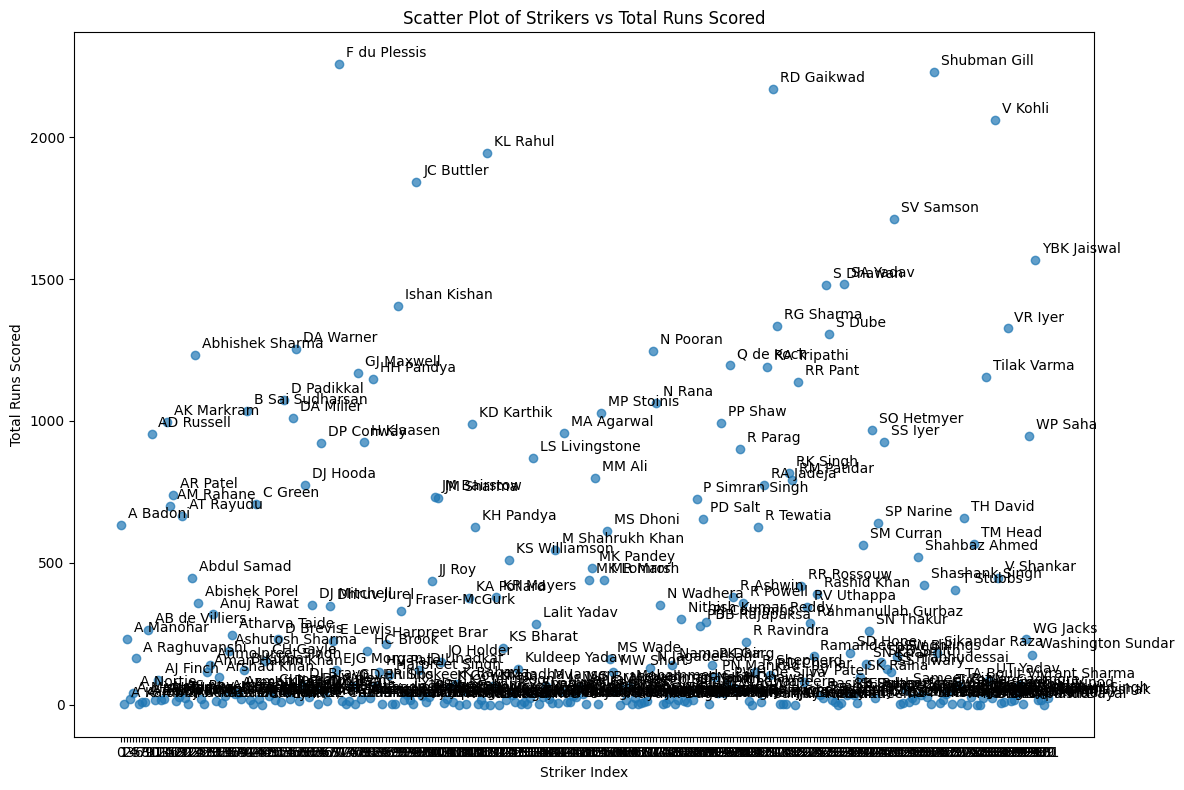

In [17]:

# Create the scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(data.index, data['totalrunsscored'], alpha=0.7)
plt.xlabel('Striker Index')  # Use index for x-axis
plt.ylabel('Total Runs Scored')
plt.title('Scatter Plot of Strikers vs Total Runs Scored')

# Add labels for each point using the striker names
for i, txt in enumerate(data['striker']):
    plt.annotate(txt, (data.index[i], data['totalrunsscored'][i]), 
                 xytext=(5, 5), textcoords='offset points')

plt.xticks(data.index)  # Set x-ticks to be the index
plt.tight_layout()
plt.show()

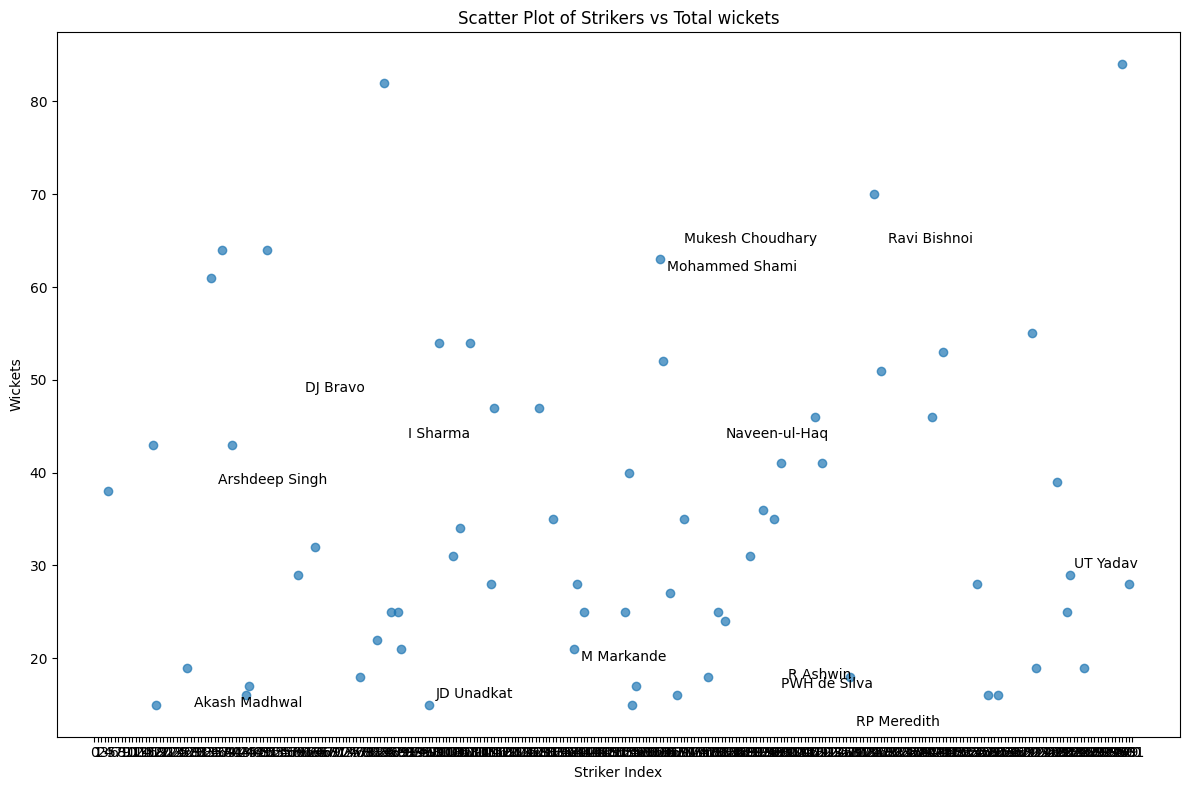

In [25]:
# Create the scatter plot
plt.figure(figsize=(12, 8))

# players with economy 10 and less and more than 5 wickets
data['economyrate'] = pd.to_numeric(data['economyrate'], errors='coerce')

# Now apply the filter
modified_data = data[
    (data['economyrate'].notna()) &  # Exclude NaN values
    (data['economyrate'] <= 10.00) & 
    (data['totalwickets'] >= 15)
]

plt.scatter(modified_data.index, modified_data['totalwickets'], alpha=0.7)
plt.xlabel('Striker Index')  # Use index for x-axis
plt.ylabel('Wickets')
plt.title('Scatter Plot of Strikers vs Total wickets')

# Add labels for each point using the striker names
for i, txt in enumerate(modified_data['striker']):
    plt.annotate(txt, (modified_data.index[i], data['totalwickets'][i]), 
                 xytext=(5, 5), textcoords='offset points')

plt.xticks(data.index)  # Set x-ticks to be the index
plt.tight_layout()
plt.show()

Now ranking each payers based on the rule based ranking system on the scale of 100

In [26]:
ranking_data = data.copy()

# Normalize metrics
metrics_to_normalize = ['totalrunsscored', 'Total_batting_average', 'batting_strike_rate', 'totalwickets']
for metric in metrics_to_normalize:
    ranking_data[f'{metric}_norm'] = (ranking_data[metric] - ranking_data[metric].min()) / (ranking_data[metric].max() - ranking_data[metric].min())

# Normalize economy rate (lower is better)
ranking_data['economyrate_norm'] = 1 - (ranking_data['economyrate'] - ranking_data['economyrate'].min()) / (ranking_data['economyrate'].max() - ranking_data['economyrate'].min())

# Assign weights
batting_weights = {
    'totalrunsscored_norm': 0.4,
    'Total_batting_average_norm': 0.3,
    'batting_strike_rate_norm': 0.3
}

bowling_weights = {
    'totalwickets_norm': 0.6,
    'economyrate_norm': 0.4
}

# Determine player type
def determine_player_type(row):
    if row['totalrunsscored'] >= 100 and row['totalwickets'] <= 2 and row['totalballsfaced'] >= 40:
        return 'Batsman'
    elif row['totalwickets'] > 5 and row['totalrunsscored'] <= 100:
        return 'Bowler'
    elif row['totalwickets'] >= 3 and row['totalrunsscored'] >= 100:
        return 'All-rounder'
    return 'Other Players'

ranking_data['Player_type'] = ranking_data.apply(determine_player_type, axis=1)

# Calculate scores based on player type
def calculate_score(row):
    if row['Player_type'] == 'Batsman':
        return sum(row[metric] * weight for metric, weight in batting_weights.items()) * 100
    elif row['Player_type'] == 'Bowler':
        return sum(row[metric] * weight for metric, weight in bowling_weights.items()) * 100
    elif row['Player_type'] == 'All-rounder':
        batting_score = sum(row[metric] * weight for metric, weight in batting_weights.items()) * 100
        bowling_score = sum(row[metric] * weight for metric, weight in bowling_weights.items()) * 100
        return (batting_score + bowling_score) / 2
    return 0

ranking_data['Overall_score'] = ranking_data.apply(calculate_score, axis=1)

# Rank players within each category
ranking_data['Rank'] = ranking_data.groupby('Player_type')['Overall_score'].rank(ascending=False, method='min')

# Sort the dataframe by Player_type and Rank
ranked_data = ranking_data.sort_values(['Player_type', 'Rank'])

# Display the ranked players
for player_type in ranked_data['Player_type'].unique():
    print(f"\n## {player_type}")
    players = ranked_data[ranked_data['Player_type'] == player_type]
    for _, player in players.iterrows():
        print(f"{player['Rank']:.0f}. {player['striker']} (Score: {player['Overall_score']:.2f})")


## All-rounder
1. Rashid Khan (Score: 54.49)
2. AD Russell (Score: 51.74)
3. RA Jadeja (Score: 51.51)
4. SP Narine (Score: 51.03)
5. HV Patel (Score: 50.57)
6. AR Patel (Score: 48.79)
7. GJ Maxwell (Score: 44.31)
8. HH Pandya (Score: 43.26)
9. R Ashwin (Score: 42.11)
10. MM Ali (Score: 42.06)
11. C Green (Score: 41.54)
12. SN Thakur (Score: 41.53)
13. SM Curran (Score: 41.37)
14. Abhishek Sharma (Score: 40.63)
15. Kuldeep Yadav (Score: 40.56)
16. MP Stoinis (Score: 40.25)
17. KH Pandya (Score: 39.32)
18. PJ Cummins (Score: 39.18)
19. LS Livingstone (Score: 38.86)
20. VR Iyer (Score: 38.28)
21. B Kumar (Score: 37.00)
22. RD Chahar (Score: 36.24)
23. N Rana (Score: 36.20)
24. T Stubbs (Score: 36.01)
25. Harpreet Brar (Score: 34.72)
26. MR Marsh (Score: 34.28)
27. JO Holder (Score: 33.75)
28. Shahbaz Ahmed (Score: 32.73)
29. R Tewatia (Score: 32.62)
30. DJ Hooda (Score: 31.43)
31. KA Pollard (Score: 31.00)
32. Ramandeep Singh (Score: 30.64)
33. Nithish Kumar Reddy (Score: 29.50)
34. V Sh

In [27]:
ranking_data.head()

,Unnamed: 0,striker,totalrunsscored,Total_batting_average,batting_strike_rate,totalballsfaced,totalwickets,economyrate,oversbowled_clean,totalrunsscored_norm,Total_batting_average_norm,batting_strike_rate_norm,totalwickets_norm,economyrate_norm,Player_type,Overall_score,Rank
0,0,A Badoni,634.0,24.384615,125.54,505.0,2.0,9.27,4.1,0.280904,0.353400,0.418467,0.023810,0.652418,Batsman,34.392161,49.0
1,1,A Kamboj,2.0,0.000000,100.00,2.0,2.0,11.07,11.2,0.000886,0.000000,0.333333,0.023810,0.584927,Other Players,0.000000,1.0
2,2,A Manohar,231.0,16.500000,127.62,181.0,0.0,0.00,0.0,0.102348,0.239130,0.425400,0.000000,1.000000,Batsman,24.029843,79.0
3,3,A Mishra,19.0,19.000000,63.33,30.0,14.0,7.98,32.1,0.008418,0.275362,0.211100,0.166667,0.700787,Bowler,38.031496,42.0
4,4,A Nortje,42.0,8.400000,93.33,45.0,38.0,9.57,120.1,0.018609,0.121739,0.311100,0.452381,0.641170,Bowler,52.789651,15.0


In [29]:
ranking_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  302 non-null    int64  
 1   striker                     302 non-null    object 
 2   totalrunsscored             302 non-null    float64
 3   Total_batting_average       302 non-null    float64
 4   batting_strike_rate         302 non-null    float64
 5   totalballsfaced             302 non-null    float64
 6   totalwickets                302 non-null    float64
 7   economyrate                 302 non-null    float64
 8   oversbowled_clean           302 non-null    float64
 9   totalrunsscored_norm        302 non-null    float64
 10  Total_batting_average_norm  302 non-null    float64
 11  batting_strike_rate_norm    302 non-null    float64
 12  totalwickets_norm           302 non-null    float64
 13  economyrate_norm            302 non

Random forest model (regression) to predict the over all score

In [31]:
model_data = ranking_data

In [32]:
# Prepare the features and target
X = model_data.drop(['Unnamed: 0', 'striker', 'Overall_score'], axis=1)
y = model_data['Overall_score']

In [33]:
# Encode categorical variables
le = LabelEncoder()
X['Player_type'] = le.fit_transform(X['Player_type'])

In [34]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

In [36]:

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
# Accuracy of the model r2 * 100

In [38]:
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

Mean Squared Error: 3.365822488403902
R-squared Score: 0.9921912055446288


In [39]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
                       feature  importance
12                 Player_type    0.744092
13                        Rank    0.243351
10           totalwickets_norm    0.002194
4                 totalwickets    0.002020
0              totalrunsscored    0.001599
6            oversbowled_clean    0.001349
7         totalrunsscored_norm    0.001310
3              totalballsfaced    0.001267
9     batting_strike_rate_norm    0.000919
2          batting_strike_rate    0.000782
8   Total_batting_average_norm    0.000373
1        Total_batting_average    0.000350
5                  economyrate    0.000254
11            economyrate_norm    0.000139


In [ ]:
# Predict for next season
# Assume you have a dataframe 'next_season_data' with the same features as X
# next_season_predictions = rf_model.predict(next_season_data)
# print("Predictions for next season:", next_season_predictions)

In [41]:
new_data = pd.DataFrame({
    'totalrunsscored': [30],  # Example value
    'Total_batting_average': [15],  # Example value
    'batting_strike_rate': [120],  # Example value
    'totalballsfaced': [25],  # Example value
    'totalwickets': [2],  # Example value
    'economyrate': [6],  # Example value
    'oversbowled_clean': [5],  # Example value
    'totalrunsscored_norm': [0.01],  # Example normalized value
    'Total_batting_average_norm': [0.02],  # Example normalized value
    'batting_strike_rate_norm': [0.03],  # Example normalized value
    'totalwickets_norm': [0.04],  # Example normalized value
    'economyrate_norm': [0.05],  # Example normalized value
    'Player_type': ['Bowler'],
    'Rank': [1]  # Example player type
})

# Encode the 'Player_type' for the new data
new_data['Player_type'] = le.transform(new_data['Player_type'])

# Make predictions for the new input data
predicted_score = rf_model.predict(new_data)

# Display the predicted overall score
print(f"Predicted Overall Score: {predicted_score[0]}")

Predicted Overall Score: 69.21416653106913


In [42]:
new_data

,totalrunsscored,Total_batting_average,batting_strike_rate,totalballsfaced,totalwickets,economyrate,oversbowled_clean,totalrunsscored_norm,Total_batting_average_norm,batting_strike_rate_norm,totalwickets_norm,economyrate_norm,Player_type,Rank
0,30,15,120,25,2,6,5,0.01,0.02,0.03,0.04,0.05,2,1


Visualizing the model

Actual vs Predicted Values Scatter Plot: This plot shows how well the predicted values align with the actual values. Points closer to the red dashed line indicate better predictions.

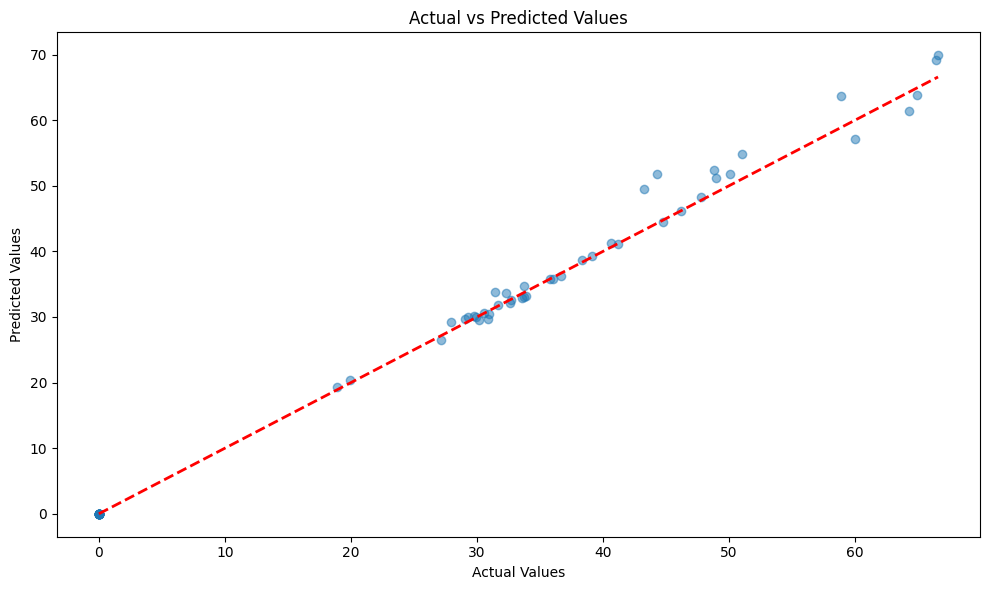

In [43]:
# 1. Actual vs Predicted values scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.tight_layout()
plt.show()

Residuals Plot: This plot helps identify any patterns in the residuals (prediction errors). Ideally, the residuals should be randomly scattered around the horizontal line at y=0.

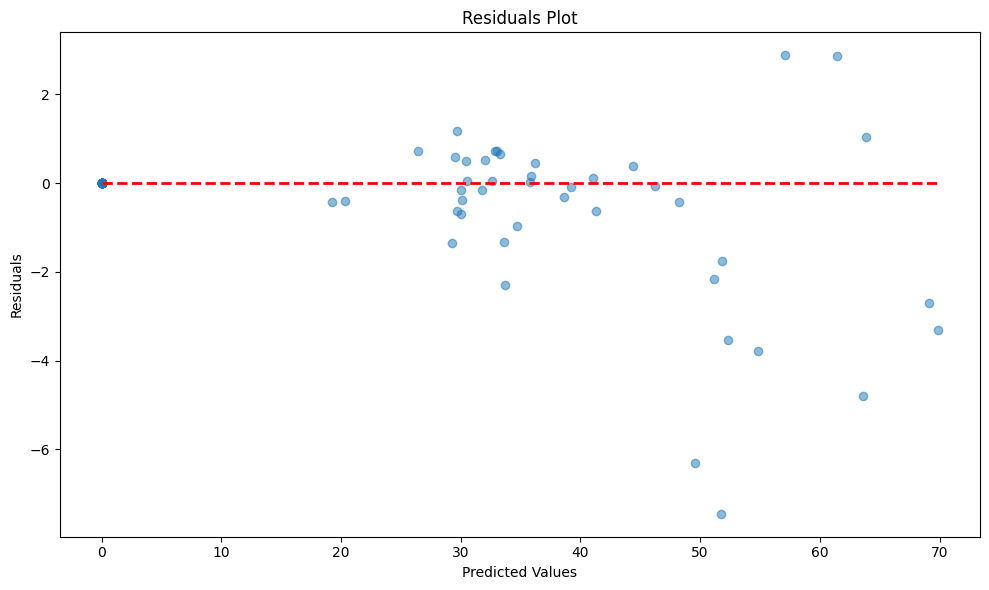

In [44]:
# 2. Residuals plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.plot([y_pred.min(), y_pred.max()], [0, 0], 'r--', lw=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.tight_layout()
plt.show()

Prediction Error Distribution Histogram: This histogram shows the distribution of prediction errors. A distribution centered around zero and symmetric indicates good model performance.

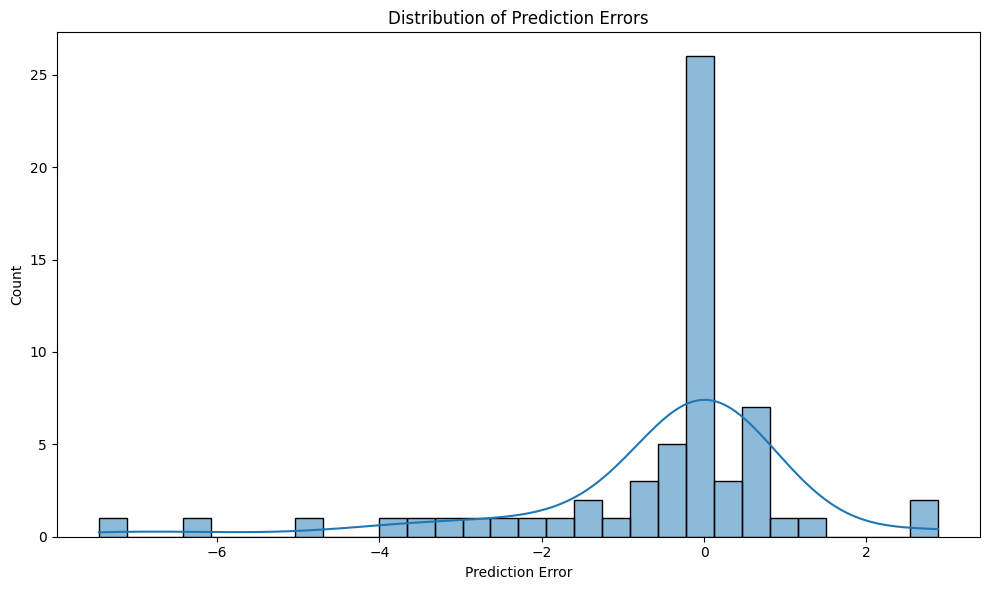

In [46]:
# 4. Prediction error distribution histogram
errors = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Distribution of Prediction Errors')
plt.tight_layout()
plt.show()

